In [1]:
%matplotlib inline

import os
import sys
genre_class_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print("Loading Genre_Classification system from path", genre_class_path)
sys.path.append(genre_class_path)

import numpy as np
import pandas as pd
import tensorflow as tf
import json
import random

Loading Genre_Classification system from path /mnt/d/UNIV NOTES/Y4S1/DSA4199/genre_classification


2022-11-15 17:44:40.350153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 17:44:40.350282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kathyij74/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
dataset_wkspc = os.path.join(genre_class_path, 'workspace', 'gb_input')
data_path = os.path.join(dataset_wkspc, 'trigram.csv')

trigram_df = pd.read_csv(data_path)
trigram_df = trigram_df.iloc[:,1:]

In [4]:
dataset_wkspc = os.path.join(genre_class_path, 'workspace', 'gb_input')
data_path = os.path.join(dataset_wkspc, 'data_index.json')

with open(data_path) as f:
    data_json = json.load(f)

In [5]:
index = []
for entry in data_json:
    index.append(entry['index'])

In [6]:
index[:10]

['10002',
 '10005',
 '10008',
 '10046',
 '10067',
 '10094',
 '10109',
 '10124',
 '1014',
 '10234']

In [7]:
trigram_df.index = index

In [8]:
trigram_df.head()

,"('NNS', 'NNPS', 'VBD')","('PRP', 'PDT', 'VB')","('FW', 'NNP', 'POS')","('RBR', 'WRB', 'PRP$')","('VBG', 'PRP$', 'VBN')","('NNS', 'VBZ', 'VBG')","('FW', 'IN', 'JJS')","('WRB', 'POS', 'NNS')","('VBG', 'CD', 'VBD')","('VBG', 'VBZ', 'RB')",...,"('NN', 'WDT', 'VBG')","('JJ', 'VBD', 'PDT')","('PRP$', 'RP', 'CC')","('JJS', 'NN', 'DT')","('WP', 'POS', 'VBG')","('POS', 'PRP$', 'RBS')","('WP$', 'JJR', 'NN')","('NN', 'NNP', 'VBZ')","('VBP', 'EX', 'TO')",subjects
10002,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
10005,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,5
10008,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
10046,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
10067,0,0,0,0,1,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2


In [9]:
random.seed(42)

train = random.sample(range(0, len(trigram_df)), int(len(trigram_df)*0.7))
test = [x for x in range(0, len(trigram_df)) if x not in train]

print(train[:20])
print(test[:20])
print(len(train))
print(len(test))

[2619, 456, 102, 3037, 1126, 1003, 914, 571, 3016, 419, 2771, 3033, 3654, 2233, 356, 2418, 1728, 130, 122, 383]
[0, 5, 7, 9, 12, 15, 17, 19, 20, 21, 27, 30, 35, 36, 37, 40, 42, 43, 44, 45]
2722
1167


In [10]:
train_df = trigram_df.iloc[train,]
test_df = trigram_df.iloc[test,]

print(train_df.shape)
print(test_df.shape)

(2722, 24216)
(1167, 24216)


In [11]:
train_df.head()

,"('NNS', 'NNPS', 'VBD')","('PRP', 'PDT', 'VB')","('FW', 'NNP', 'POS')","('RBR', 'WRB', 'PRP$')","('VBG', 'PRP$', 'VBN')","('NNS', 'VBZ', 'VBG')","('FW', 'IN', 'JJS')","('WRB', 'POS', 'NNS')","('VBG', 'CD', 'VBD')","('VBG', 'VBZ', 'RB')",...,"('NN', 'WDT', 'VBG')","('JJ', 'VBD', 'PDT')","('PRP$', 'RP', 'CC')","('JJS', 'NN', 'DT')","('WP', 'POS', 'VBG')","('POS', 'PRP$', 'RBS')","('WP$', 'JJR', 'NN')","('NN', 'NNP', 'VBZ')","('VBP', 'EX', 'TO')",subjects
6407,0,0,0,0,1,0,0,0,0,1,...,0,1,0,1,0,0,0,3,0,3
20719,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,0,4
12725,0,0,0,0,0,0,0,0,0,0,...,1,1,0,3,0,0,0,0,0,3
24104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
30004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [12]:
train_df['subjects'].value_counts()

5    1231
1     378
2     318
4     296
6     258
3     241
Name: subjects, dtype: int64

In [13]:
test_df.head()

,"('NNS', 'NNPS', 'VBD')","('PRP', 'PDT', 'VB')","('FW', 'NNP', 'POS')","('RBR', 'WRB', 'PRP$')","('VBG', 'PRP$', 'VBN')","('NNS', 'VBZ', 'VBG')","('FW', 'IN', 'JJS')","('WRB', 'POS', 'NNS')","('VBG', 'CD', 'VBD')","('VBG', 'VBZ', 'RB')",...,"('NN', 'WDT', 'VBG')","('JJ', 'VBD', 'PDT')","('PRP$', 'RP', 'CC')","('JJS', 'NN', 'DT')","('WP', 'POS', 'VBG')","('POS', 'PRP$', 'RBS')","('WP$', 'JJR', 'NN')","('NN', 'NNP', 'VBZ')","('VBP', 'EX', 'TO')",subjects
10002,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
10094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,3
10124,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,6
10234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,3,0,3
10372,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,3,0,6


In [14]:
test_df['subjects'].value_counts()

5    511
2    151
1    145
4    131
6    116
3    113
Name: subjects, dtype: int64

In [15]:
features_col = train_df.iloc[:,:-1]
sparse = {}
for feature in features_col.columns:
    sparse[feature] = ((features_col[feature] == 0).sum()/len(features_col))*100
non_sparse = [x for x in sparse.keys() if sparse[x] <= 80]

In [16]:
features_col.head()

,"('NNS', 'NNPS', 'VBD')","('PRP', 'PDT', 'VB')","('FW', 'NNP', 'POS')","('RBR', 'WRB', 'PRP$')","('VBG', 'PRP$', 'VBN')","('NNS', 'VBZ', 'VBG')","('FW', 'IN', 'JJS')","('WRB', 'POS', 'NNS')","('VBG', 'CD', 'VBD')","('VBG', 'VBZ', 'RB')",...,"('WDT', 'POS', 'VBG')","('NN', 'WDT', 'VBG')","('JJ', 'VBD', 'PDT')","('PRP$', 'RP', 'CC')","('JJS', 'NN', 'DT')","('WP', 'POS', 'VBG')","('POS', 'PRP$', 'RBS')","('WP$', 'JJR', 'NN')","('NN', 'NNP', 'VBZ')","('VBP', 'EX', 'TO')"
6407,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,3,0
20719,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
12725,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,3,0,0,0,0,0
24104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# remove sparse columns aka columns with 0 values more than 80%
features_col = train_df.iloc[:, :-1]
subjects = train_df.iloc[:, -1:]
train_index = train_df.index
sparse = {}
for feature in features_col.columns:
    sparse[feature] = ((features_col[feature] == 0).sum()/len(features_col))*100
non_sparse = [x for x in sparse.keys() if sparse[x] <= 80]

In [18]:
body_length = {}
for entry in data_json:
    body_length[entry['index']] = entry['body_length']

In [19]:
body_length['6407']

225019

In [20]:
train_index[:10]

Index(['6407', '20719', '12725', '24104', '30004', '29060', '2789', '22540',
       '2344', '20152'],
      dtype='object')

In [21]:
# rescale the data by dividing it with row sum then standardize it
from sklearn.preprocessing import StandardScaler

train_df = train_df[non_sparse]
for number in train_index:
    train_df.loc[number,:] = train_df.loc[number,:].div(int(body_length[number]))
train_df['subjects'] = subjects

In [22]:
train_df.head()

,"('WP', 'VBP', 'JJ')","('IN', 'VBP', 'RB')","('NNS', 'CC', 'VBN')","('RBR', 'VB', 'DT')","('IN', 'VBG', 'VBN')","('PRP', 'TO', 'NN')","('IN', 'WDT', 'PRP')","('PRP', 'VBP', 'WRB')","('VB', 'VBD', 'RB')","('IN', 'PRP', 'WRB')",...,"('NNP', 'NNP', 'VBD')","('VB', 'CD', 'NN')","('VBD', 'IN', 'NN')","('PRP$', 'NNS', 'WRB')","('RB', 'VBD', 'RP')","('NNS', 'CC', 'TO')","('VB', 'DT', 'TO')","('JJS', 'NN', 'DT')","('NN', 'NNP', 'VBZ')",subjects
6407,0.000031,0.000018,0.000004,0.000013,0.000151,0.000027,0.000791,0.000013,0.000031,0.000022,...,0.000004,0.000027,0.000573,0.000009,0.000027,0.000009,0.000000,0.000004,0.000013,3
20719,0.000000,0.000020,0.000000,0.000000,0.000112,0.000010,0.000335,0.000010,0.000112,0.000071,...,0.000030,0.000041,0.000711,0.000010,0.000061,0.000000,0.000030,0.000000,0.000030,4
12725,0.000034,0.000026,0.000026,0.000000,0.000086,0.000026,0.000608,0.000000,0.000043,0.000009,...,0.000026,0.000051,0.000848,0.000000,0.000034,0.000009,0.000017,0.000026,0.000000,3
24104,0.000000,0.000049,0.000000,0.000000,0.000000,0.000000,0.000148,0.000000,0.000000,0.000000,...,0.000296,0.000099,0.000691,0.000049,0.000049,0.000000,0.000000,0.000000,0.000000,5
30004,0.000000,0.000129,0.000000,0.000000,0.000000,0.000000,0.000387,0.000000,0.000000,0.000000,...,0.000258,0.000000,0.000258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5


In [23]:
from sklearn import svm
from matplotlib import pyplot as plt

X = train_df.iloc[:, :-1].to_numpy()
y = train_df.iloc[:, -1:].to_numpy().flatten()

clf = svm.SVC(kernel='linear')
clf.fit(X, y)

SVC(kernel='linear')

In [24]:
clf2 = svm.LinearSVC(loss='hinge', max_iter=100000)
clf2.fit(X, y)

LinearSVC(loss='hinge', max_iter=100000)

In [25]:
clf3 = svm.SVC(kernel='linear', class_weight='balanced')
clf3.fit(X, y)

SVC(class_weight='balanced', kernel='linear')

In [26]:
clf4 = svm.LinearSVC(loss='hinge', class_weight='balanced', max_iter=100000)
clf4.fit(X, y)

LinearSVC(class_weight='balanced', loss='hinge', max_iter=100000)

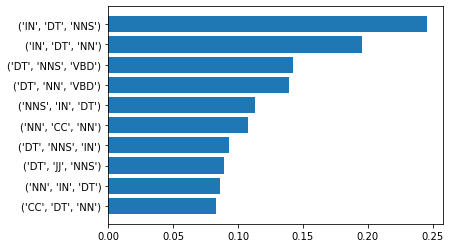

In [27]:
# check feature importance

def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names)))
    plt.barh(range(10), imp[-10:], align='center')
    plt.yticks(range(10), names[-10:])
    plt.show()
    
f_importances(clf.coef_[0], non_sparse)

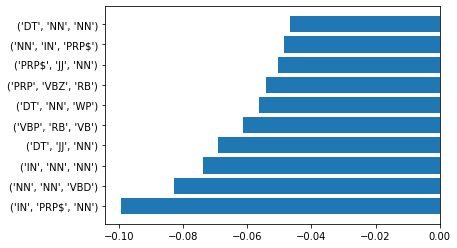

In [28]:
# check feature importance

def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names)))
    plt.barh(range(10), imp[:10], align='center')
    plt.yticks(range(10), names[:10])
    plt.show()
    
f_importances(clf.coef_[0], non_sparse)

In [29]:
clf2.coef_.shape

(6, 4657)

In [30]:
# preprocess test data
test_subjects = test_df['subjects']
test_index = test_df.index
test_df = test_df[non_sparse]
#test_df = test_df.div(test_df.sum(axis=1), axis=0)
for number in test_index:
    test_df.loc[number,:] = test_df.loc[number,:].div(int(body_length[number]))
test_df['subjects'] = test_subjects

In [31]:
test_df.head()

,"('WP', 'VBP', 'JJ')","('IN', 'VBP', 'RB')","('NNS', 'CC', 'VBN')","('RBR', 'VB', 'DT')","('IN', 'VBG', 'VBN')","('PRP', 'TO', 'NN')","('IN', 'WDT', 'PRP')","('PRP', 'VBP', 'WRB')","('VB', 'VBD', 'RB')","('IN', 'PRP', 'WRB')",...,"('NNP', 'NNP', 'VBD')","('VB', 'CD', 'NN')","('VBD', 'IN', 'NN')","('PRP$', 'NNS', 'WRB')","('RB', 'VBD', 'RP')","('NNS', 'CC', 'TO')","('VB', 'DT', 'TO')","('JJS', 'NN', 'DT')","('NN', 'NNP', 'VBZ')",subjects
10002,0.000000,0.000046,0.000015,0.000046,0.000106,0.000030,0.000289,0.000000,0.000274,0.000015,...,0.000015,0.000015,0.000973,0.000015,0.000061,0.000000,0.000000,0.000000,0.000000,5
10094,0.000010,0.000030,0.000050,0.000000,0.000030,0.000020,0.000298,0.000010,0.000139,0.000050,...,0.000010,0.000020,0.001311,0.000020,0.000079,0.000010,0.000020,0.000020,0.000000,3
10124,0.000053,0.000018,0.000088,0.000000,0.000018,0.000018,0.000140,0.000018,0.000035,0.000000,...,0.000018,0.000000,0.000840,0.000018,0.000070,0.000018,0.000000,0.000018,0.000000,6
10234,0.000011,0.000011,0.000044,0.000000,0.000067,0.000022,0.000189,0.000011,0.000022,0.000033,...,0.000033,0.000078,0.000477,0.000000,0.000111,0.000000,0.000000,0.000011,0.000033,3
10372,0.000035,0.000027,0.000009,0.000009,0.000009,0.000009,0.000124,0.000018,0.000044,0.000018,...,0.000071,0.000027,0.001363,0.000018,0.000053,0.000009,0.000009,0.000000,0.000027,6


In [32]:
# make prediction

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1:].to_numpy().flatten()

pred = clf.predict(X_test)

In [33]:
pred

array([5, 5, 5, ..., 5, 5, 5])

In [34]:
# confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
# import seaborn as sns

cm = metrics.confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, index = [1,2,3,4,5,6], columns = [1,2,3,4,5,6])
#plt.figure()
#sns.heatmap(cm_df, annot=True)
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Values')
#plt.xlabel('Predicted Values')
#plt.show()

In [35]:
cm

array([[  0,   0,   0,   0, 145,   0],
       [  0,   0,   0,   0, 151,   0],
       [  0,   0,   0,   0, 113,   0],
       [  0,   0,   0,   0, 131,   0],
       [  0,   0,   0,   0, 511,   0],
       [  0,   0,   0,   0, 116,   0]])

In [36]:
cm.diagonal()/cm.sum(axis=1)

array([0., 0., 0., 0., 1., 0.])

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred, target_names=['Adventure stories','Detective and mystery stories','Historical fiction',
                                                        'Love stories','Science fiction','Western stories'], digits=3))

                               precision    recall  f1-score   support

            Adventure stories      0.000     0.000     0.000       145
Detective and mystery stories      0.000     0.000     0.000       151
           Historical fiction      0.000     0.000     0.000       113
                 Love stories      0.000     0.000     0.000       131
              Science fiction      0.438     1.000     0.609       511
              Western stories      0.000     0.000     0.000       116

                     accuracy                          0.438      1167
                    macro avg      0.073     0.167     0.102      1167
                 weighted avg      0.192     0.438     0.267      1167



/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# make prediction

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1:].to_numpy().flatten()

pred2 = clf2.predict(X_test)

In [39]:
pred2

array([5, 3, 5, ..., 4, 5, 5])

In [40]:
# confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
# import seaborn as sns

cm2 = metrics.confusion_matrix(y_test, pred2)
cm_df2 = pd.DataFrame(cm2, index = [1,2,3,4,5,6], columns = [1,2,3,4,5,6])
#plt.figure()
#sns.heatmap(cm_df, annot=True)
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Values')
#plt.xlabel('Predicted Values')
#plt.show()

In [41]:
cm2

array([[  9,   4,   2,   3, 127,   0],
       [  0,  20,   0,  10, 121,   0],
       [  1,   0,  14,   5,  93,   0],
       [  0,   6,   0,  36,  89,   0],
       [  0,   0,   0,   1, 510,   0],
       [  0,   0,   0,   1, 108,   7]])

In [42]:
cm2.diagonal()/cm2.sum(axis=1)

array([0.06206897, 0.13245033, 0.12389381, 0.27480916, 0.99804305,
       0.06034483])

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred2, target_names=['Adventure stories','Detective and mystery stories','Historical fiction',
                                                        'Love stories','Science fiction','Western stories'], digits=3))

                               precision    recall  f1-score   support

            Adventure stories      0.900     0.062     0.116       145
Detective and mystery stories      0.667     0.132     0.221       151
           Historical fiction      0.875     0.124     0.217       113
                 Love stories      0.643     0.275     0.385       131
              Science fiction      0.487     0.998     0.654       511
              Western stories      1.000     0.060     0.114       116

                     accuracy                          0.511      1167
                    macro avg      0.762     0.275     0.285      1167
                 weighted avg      0.667     0.511     0.405      1167



In [44]:
# make prediction

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1:].to_numpy().flatten()

pred3 = clf3.predict(X_test)

In [45]:
pred3

array([6, 6, 6, ..., 6, 6, 6])

In [46]:
# confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
# import seaborn as sns

cm3 = metrics.confusion_matrix(y_test, pred3)
cm_df3 = pd.DataFrame(cm3, index = [1,2,3,4,5,6], columns = [1,2,3,4,5,6])
#plt.figure()
#sns.heatmap(cm_df, annot=True)
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Values')
#plt.xlabel('Predicted Values')
#plt.show()

In [47]:
cm3

array([[  0,   0,   0,   0,   0, 145],
       [  0,   0,   0,   0,   0, 151],
       [  0,   0,   0,   0,   0, 113],
       [  0,   0,   0,   0,   0, 131],
       [  0,   0,   0,   0,   0, 511],
       [  0,   0,   0,   0,   0, 116]])

In [48]:
cm3.diagonal()/cm3.sum(axis=1)

array([0., 0., 0., 0., 0., 1.])

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred3, target_names=['Adventure stories','Detective and mystery stories','Historical fiction',
                                                        'Love stories','Science fiction','Western stories'], digits=3))

                               precision    recall  f1-score   support

            Adventure stories      0.000     0.000     0.000       145
Detective and mystery stories      0.000     0.000     0.000       151
           Historical fiction      0.000     0.000     0.000       113
                 Love stories      0.000     0.000     0.000       131
              Science fiction      0.000     0.000     0.000       511
              Western stories      0.099     1.000     0.181       116

                     accuracy                          0.099      1167
                    macro avg      0.017     0.167     0.030      1167
                 weighted avg      0.010     0.099     0.018      1167



/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
# make prediction

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1:].to_numpy().flatten()

pred4 = clf4.predict(X_test)

In [51]:
pred4

array([2, 3, 5, ..., 4, 4, 4])

In [52]:
# confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
# import seaborn as sns

cm4 = metrics.confusion_matrix(y_test, pred4)
cm_df4 = pd.DataFrame(cm4, index = [1,2,3,4,5,6], columns = [1,2,3,4,5,6])
#plt.figure()
#sns.heatmap(cm_df, annot=True)
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Values')
#plt.xlabel('Predicted Values')
#plt.show()

In [53]:
cm4

array([[ 30,  13,  29,  12,  55,   6],
       [  3,  60,   9,  43,  32,   4],
       [  4,   0,  61,  14,  29,   5],
       [  0,   2,  12,  76,  33,   8],
       [  2,   5,   1,   5, 492,   6],
       [  2,   2,  11,  17,  36,  48]])

In [54]:
cm4.diagonal()/cm4.sum(axis=1)

array([0.20689655, 0.39735099, 0.53982301, 0.58015267, 0.962818  ,
       0.4137931 ])

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred4, target_names=['Adventure stories','Detective and mystery stories','Historical fiction',
                                                        'Love stories','Science fiction','Western stories'], digits=3))

                               precision    recall  f1-score   support

            Adventure stories      0.732     0.207     0.323       145
Detective and mystery stories      0.732     0.397     0.515       151
           Historical fiction      0.496     0.540     0.517       113
                 Love stories      0.455     0.580     0.510       131
              Science fiction      0.727     0.963     0.828       511
              Western stories      0.623     0.414     0.497       116

                     accuracy                          0.657      1167
                    macro avg      0.627     0.517     0.532      1167
                 weighted avg      0.665     0.657     0.626      1167

